In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
#fatiando imports
from fatiando.gravmag import normal_gravity
from fatiando import gridder, utils, mesher
from fatiando.gravmag import polyprism, prism
from fatiando.mesher import Prism
from fatiando.vis import mpl, myv

In [5]:
#densidade crosta continental
rho_c = 2.67
# densidade manto
rho_m = 3.33
# densidade agua
rho_w = 1.0

In [6]:
# topografia
# altura da 'montanha'
h1 = 1.5E3
# profundidade do mar
d = 1.0E3

In [7]:
# profundidade moho
dmoho = 30.E3
# espessura para compensar a topografia terrestre
r1 = h1*rho_c/(rho_m-rho_c)
# espessura para compensar oceano
r2 = d*(rho_c - rho_w)/(rho_m - rho_c)

In [12]:
#largura dos prismas
larg = 2.E3
# 
c_end = 2.E3
# prisma correspondente ao continente
p_continent = Prism(0, c_end, 0, larg , dmoho, dmoho + r1 , {'density':rho_c-rho_m})
# prisma correspondente ao oceano
p_ocean = Prism(c_end, c_end + 2.E3, 0, larg, dmoho-r2, dmoho, {'density':rho_m-rho_c})

In [15]:
p_continent.get_bounds()

[0.0, 2000.0, 0.0, 2000.0, 30000.0, 36068.181818181816]

In [16]:
p_ocean.get_bounds()

[2000.0, 4000.0, 0.0, 2000.0, 27469.69696969697, 30000.0]

In [33]:
xp = np.arange(0., c_end + 2.E3, 10.)
yp = np.arange(0., larg, 5.)
zp = 3.E3*np.ones(len(xp))
# calculo nos pontos (xp,yp,zp) da componente z de g
bouguer = prism.gz(xp, yp, zp, [p_continent,p_ocean])

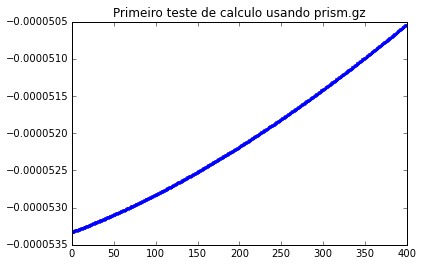

In [37]:
plt.figure()
plt.plot(bouguer,'.')
plt.title('Primeiro teste de calculo usando prism.gz')